In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

**Пути к директориям и папкам**

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

# Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

# Предварительный анализ
**Для начала посмотрим на данные**

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col = 'Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [4]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col = 'Id')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,NaN,0,0,B
15856,74,2.00,69.26,NaN,1.00,6,1.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,NaN,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,NaN,0,0,A


In [7]:
train_df.shape, test_df.shape

((10000, 19), (5000, 18))

**Приведение типов**

In [6]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
#переведём DistrictId в строку, так как мы не будем использовать эти значения напрямую
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

# Обзор данных
**Целевая переменная (Price)**

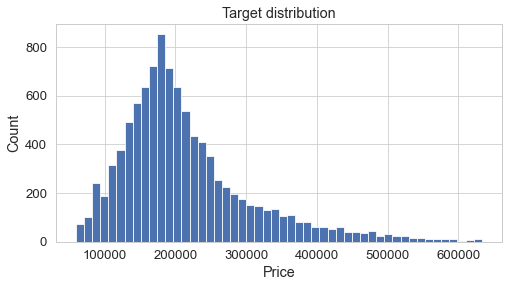

In [8]:
#построим график распределения целевой переменной
plt.figure(figsize = (8,4))

train_df['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution');

Распределение целевой переменной (Price) близко к нормальному

**Количественные переменные**

In [9]:
#посмотрим на количество уникальных значений признаков
train_df.nunique()

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

В нескольких признаках всего несколько значений, поэтому их можно будет отнести к категориальным (Rooms, Ecology_2, Ecology_3, Helthcare_2, Shops_2)

In [10]:
#рассмотрим аномальные величины
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


Аномальные значения присутствуют в нескольких признаках (KitchenSquare, HouseYear)

In [11]:
#отберём все числовые признаки по типу
feature_num_names = train_df.drop('Price', axis = 1).select_dtypes(include = ['float64', 'int']).columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

На выходе мы получили список из числовых 14 признаков

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

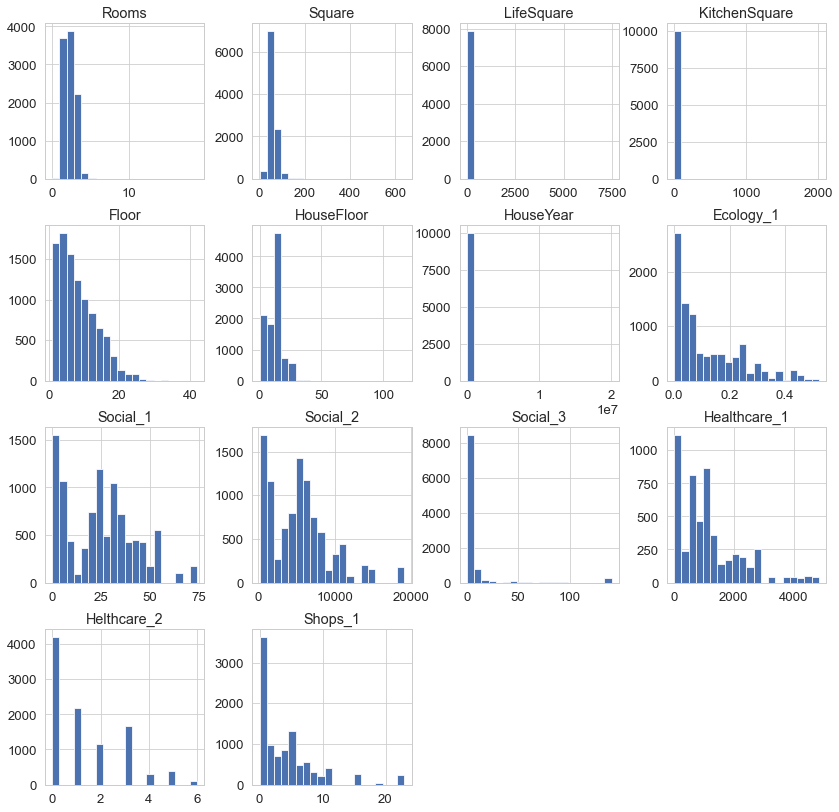

In [12]:
#построим гистограммы, чтобы посмотреть на эти признаки
train_df[feature_num_names].hist(figsize = (14, 14), bins = 20, grid = True)

Несколько признаков имеют явные выбросы, обработаем их позже

**Категориальные переменные**  
Начнём с бинарных переменных

**Ecology_2, Ecology_3, Shops_2**

In [13]:
#создадим список категориальных переменных
feature_cat_names = train_df.select_dtypes(include = 'object').columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [14]:
#рассмотрим Ecology_2
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

<AxesSubplot:xlabel='Price', ylabel='Ecology_2'>

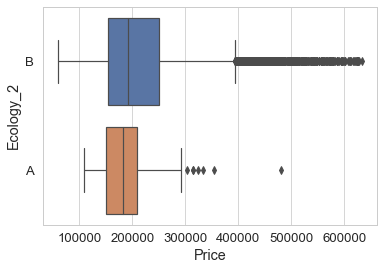

In [15]:
#посмотрим как целевая переменная отличается в этих двух категориях
sns.boxplot('Price', 'Ecology_2', data = train_df)

Разница в двух категориях минимальна

In [16]:
#рассмотрим Ecology_3
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

<AxesSubplot:xlabel='Price', ylabel='Ecology_3'>

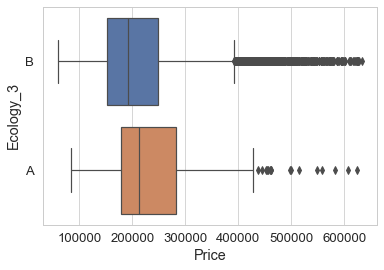

In [17]:
#посмотрим как целевая переменная отличается в этих двух категориях
sns.boxplot('Price', 'Ecology_3', data = train_df)

В отличие от Ecology_3 разница более заметна

In [18]:
#рассмотрим Shops_2
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

<AxesSubplot:xlabel='Price', ylabel='Shops_2'>

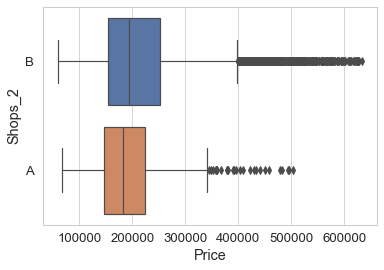

In [19]:
#посмотрим как целевая переменная отличается в этих двух категориях
sns.boxplot('Price', 'Shops_2', data = train_df)

Разница в двух категориях минимальна

**Заменим символы в бинарных категориях на числа**

In [20]:
#создадим список переменных на замену
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']
#произведем замену
train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})
#проверим результат
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

**Helthcare_2**

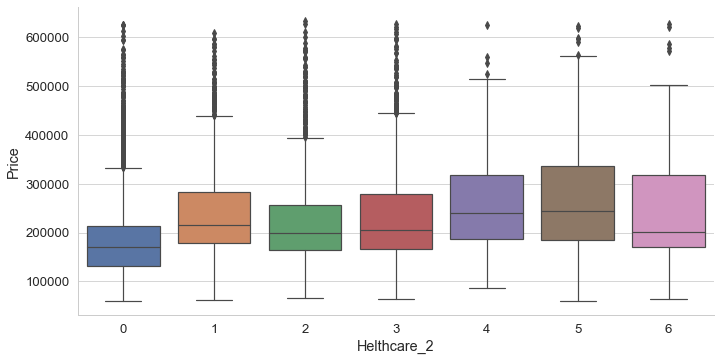

In [21]:
#посмотрим как целевая переменная зависит от Helthcare_2
sns.catplot('Helthcare_2', 'Price', data = train_df, kind="box", aspect = 2/1);

Некоторая логика прослеживается, можно попробовать объеденить некоторые категории (например: (0), (1,2,3) и (4,5,6))

# Обработка пропусков

In [22]:
train_df.isna().sum()[train_df.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

Пропущенные значения есть всего в двух категориях

**LifeSquare**

In [23]:
#посчитаем LifeSquare как разницу между Square и KitchenSquare
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

**Healthcare_1**

In [24]:
#заменим медианой
train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace = True)
test_df['Healthcare_1'].fillna(test_df['Healthcare_1'].median(), inplace = True)

# Обработка выбросов

**Rooms**

In [25]:
train_df['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
6.00        1
19.00       1
Name: Rooms, dtype: int64

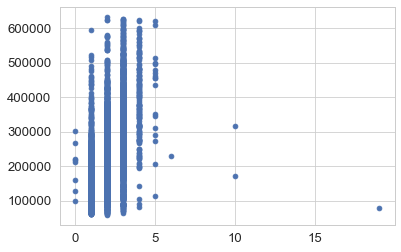

In [26]:
#построим график
plt.scatter(train_df['Rooms'], train_df['Price']);

Действительно наблюдаются выбросы, а так же есть несколько 0, либо информация отсутсвует, либо это ошибки

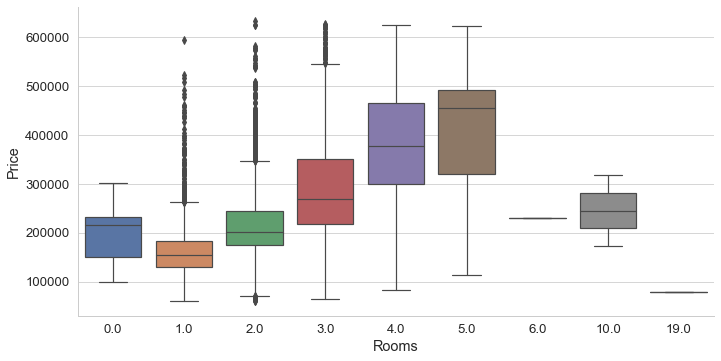

In [27]:
#посмотрим на графике
sns.catplot('Rooms', 'Price', kind="box", aspect = 2/1, data = train_df)

Нулевые значения комнат совпадают с данными по 2 комнатам

In [28]:
test_df['Rooms'].value_counts()

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
0.00        2
6.00        2
17.00       1
Name: Rooms, dtype: int64

Данные по test_df схожи

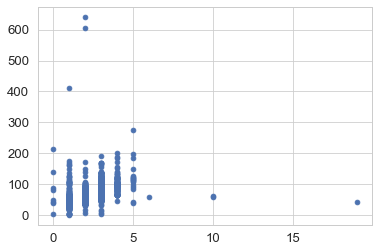

In [29]:
#посмотрим на зависимость количества комнат от площади дома
plt.scatter(train_df['Rooms'], train_df['Square']);

Выбросы так же очевидно видны

In [30]:
#посмотрим на моду
train_df['Rooms'].mode()[0]

2.0

Мода равна 2 комнатам, заменим все выбросы на моду по train

In [31]:
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]

In [32]:
#проверим результат
train_df['Rooms'].value_counts()

2.00    3892
1.00    3705
3.00    2235
4.00     150
5.00      18
Name: Rooms, dtype: int64

**Square, LifeSquare, KitchenSquare**

In [33]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.32,41.80,6.27
std,21.06,77.82,28.56
min,1.14,0.37,0.00
25%,41.77,25.49,1.00
50%,52.51,37.04,6.00
75%,65.90,49.82,9.00
max,641.07,"7,480.59","2,014.00"


Явно наблюдаются выбросы в максимальных значениях

**KitchenSquare**

In [34]:
train_df['KitchenSquare'].value_counts()

1.00        2460
8.00        1306
5.00        1169
10.00       1075
6.00        1038
9.00         843
0.00         697
7.00         609
12.00        249
11.00        233
13.00         67
14.00         51
4.00          39
15.00         31
3.00          22
16.00         16
20.00         14
17.00         12
19.00         11
18.00          6
2.00           4
22.00          3
112.00         2
51.00          2
58.00          2
37.00          2
32.00          2
41.00          2
43.00          2
30.00          2
25.00          2
39.00          1
23.00          1
123.00         1
40.00          1
48.00          1
21.00          1
72.00          1
27.00          1
63.00          1
1,970.00       1
29.00          1
66.00          1
2,014.00       1
31.00          1
78.00          1
35.00          1
42.00          1
73.00          1
60.00          1
84.00          1
26.00          1
54.00          1
36.00          1
53.00          1
96.00          1
62.00          1
75.00          1
Name: KitchenS

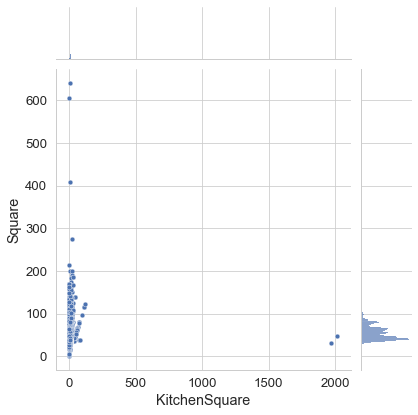

In [35]:
#построим график
sns.jointplot(train_df['KitchenSquare'], train_df['Square'], kind = 'scatter', height=6);

На графике хорошо видны выбросы

In [36]:
#посмотрим на выбросы
train_df.loc[(train_df['KitchenSquare'] > 150) | (train_df['KitchenSquare'] > train_df['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,46.45,"2,014.00",4,1.00,2014,0.07,1,1,2,629,1,900.00,0,0,0,"108,337.48"
13703,42,1.00,38.07,19.72,73.00,9,10.00,2006,0.16,1,1,21,5731,0,900.00,1,0,1,"160,488.03"
6569,27,1.00,38.22,18.72,84.00,4,17.00,2018,0.01,1,1,4,915,0,900.00,0,0,1,"99,079.96"
14679,81,1.00,32.28,19.28,"1,970.00",6,1.00,1977,0.01,1,1,30,5285,0,645.00,6,6,1,"105,539.56"


Всего 4 значения соответсвуют поставленному условию, заменим их на медиану по train

In [37]:
train_df.loc[(train_df['KitchenSquare']>150)|(train_df['KitchenSquare']>train_df['Square']), 'KitchenSquare'] = train_df['KitchenSquare'].median()
test_df.loc[(train_df['KitchenSquare']>150)|(test_df['KitchenSquare']>test_df['Square']), 'KitchenSquare'] = train_df['KitchenSquare'].median()

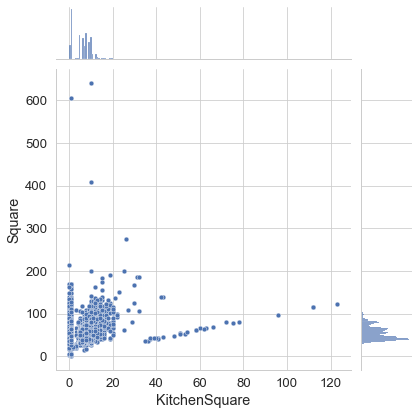

In [38]:
#ещё раз посмотрим на график
sns.jointplot(train_df['KitchenSquare'], train_df['Square'], kind = 'scatter', height=6);

Некоторые ошибки всё еще видны, возможно вернуться к ним позже

**LifeSquare**

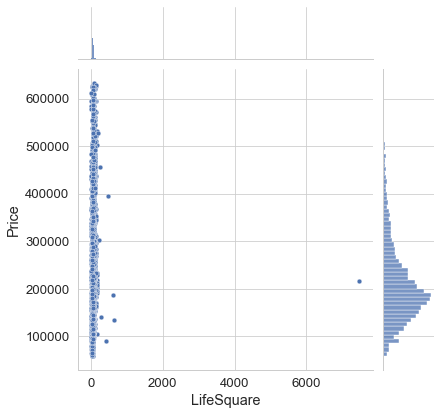

In [39]:
#построим график распределения
sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind ='scatter', height =6);

По графику явно видно ошибочное значение, а так же выбросы

In [40]:
#заменим значения больше 400 на медиану по train
train_df.loc[(train_df['LifeSquare']>400), 'LifeSquare'] = train_df['LifeSquare'].median()
test_df.loc[(test_df['LifeSquare']>400), 'LifeSquare'] = train_df['LifeSquare'].median()

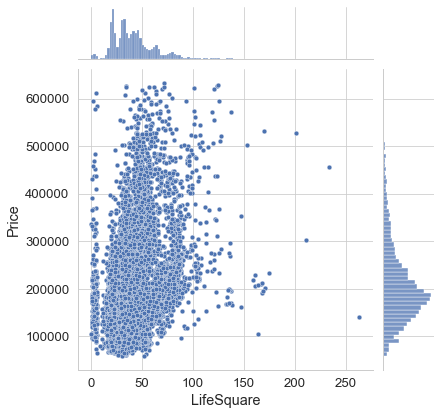

In [41]:
#перестроим график
sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind ='scatter', height =6);

Всё ещё присутствуют некоторые выбросы, возможно вернуться к этому позже

**Square**

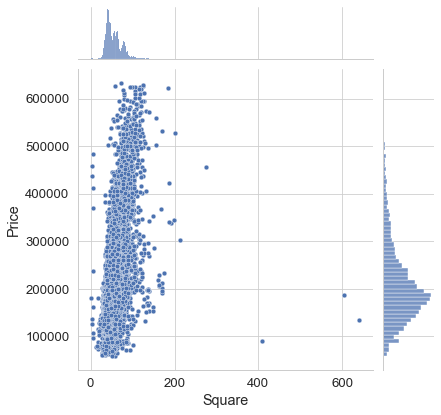

In [42]:
#построим график
sns.jointplot(train_df['Square'], train_df['Price'], kind= 'scatter', height = 6);

По графику хорошо видны выбросы, явно слишком малая цена для столь большой площади

Посмотрим на квартиры меньше 10 метров и более 400

In [43]:
train_df.loc[(train_df['Square']>400)|(train_df['Square']<10), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.00,5.50,67.63,1.00,24,22.00,1977,0.13,1,1,43,8429,3,900.00,3,9,1,"412,511.09"
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,1,1,4,915,0,900.00,0,0,1,"107,604.27"
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,1,1,5,1564,0,540.00,0,0,1,"137,597.60"
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,1,1,9,1892,0,900.00,0,1,1,"97,560.72"
9487,5,1.00,5.13,5.55,1.00,1,1.00,1977,0.15,1,1,16,3433,4,"2,643.00",4,5,1,"369,472.40"
28,9,2.00,604.71,37.04,1.00,17,18.00,1977,0.16,1,1,25,5648,1,30.00,2,4,1,"187,717.24"
2307,102,1.00,409.43,37.04,10.00,4,4.00,2016,0.24,1,1,26,3889,6,705.00,3,6,1,"90,470.43"
3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,900.00,0,0,1,"126,596.94"
4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,1,1,9,1892,0,900.00,0,1,1,"161,379.07"


In [44]:
#заменим на медиану по train
train_df.loc[(train_df['Square']>400)|(train_df['Square']<10), 'Square'] = train_df['Square'].median()
test_df.loc[(test_df['Square']>400)|(test_df['Square']<10), 'Square'] = train_df['Square'].median()

In [45]:
#проверим результат
train_df.loc[(train_df['Square']>400)|(train_df['Square']<10), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


Попробуем посмотреть на количество квартир, где общая площадь меньше жилой площади + площадь кухни

In [46]:
len(train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])])

830

Значений довольно много, посмотрим на сами цифры

In [47]:
train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23"
8054,23,1.00,42.53,43.97,1.00,3,9.00,2014,0.03,1,1,0,168,0,900.00,0,0,1,"95,338.20"
10521,38,3.00,104.21,106.34,0.00,20,0.00,2017,0.06,1,1,15,2787,2,520.00,0,7,1,"435,462.05"
7596,23,1.00,47.08,46.81,12.00,3,9.00,1977,0.01,1,1,2,475,0,900.00,0,0,1,"96,029.17"
2301,1,2.00,61.40,65.22,0.00,17,22.00,2016,0.01,1,1,1,264,0,900.00,0,1,1,"199,215.45"


Возможно были допущены ощибки при заполнении данных (перепутаны столбцы Square и LifeSquare, возможно вернуться к этому позже

In [48]:
#посмотрим ещё раз на данные
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.22,40.86,5.86
std,19.06,20.57,5.07
min,13.78,0.37,0.00
25%,41.79,25.49,1.00
50%,52.51,37.04,6.00
75%,65.89,49.77,9.00
max,275.65,263.54,123.00


Теперь данные выглядят гораздо лучше

**HouseFloor, Floor**

In [49]:
#посмотрим на количество уникальных значений этажей дома
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [50]:
#посмотрим на количество уникальных значений этажа квартиры
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

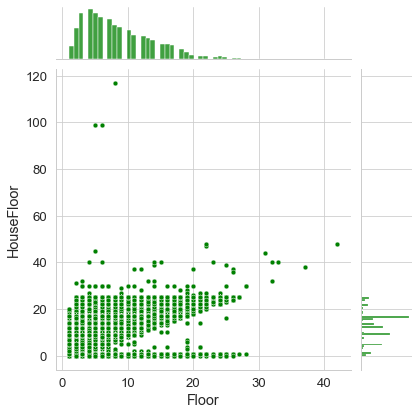

In [51]:
#посмотрим на количество квартир, где этаж выше этажа дома
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind="scatter", height=6, color='green');

Довольно много значений, где этаж квартиры выше этажности дома

In [52]:
#заменим 0 этаж на моду по train
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode() [0]
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode() [0]

In [53]:
#заменим значения выше 98 этажа на также на моду по train
train_df.loc[train_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode() [0]
test_df.loc[test_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode() [0]

In [54]:
#выведем индексы всех объектов недвижимости, где этаж квартиры выше этажности дома
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

floor_outliers_train

Int64Index([10953,  2119, 11935,  6486, 10521, 10103,  8443,  1063, 14675,
            14020,
            ...
            10361,  4660, 16050, 12590,  5071,  2237, 16159,  4145, 11553,
               77],
           dtype='int64', name='Id', length=1578)

In [55]:
#заменим значения по этим индексам на случайное значение от 1 до этажности дома
train_df.loc[floor_outliers_train, 'Floor'] = train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
test_df.loc[floor_outliers_test, 'Floor'] = test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [56]:
#проверим результат
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

floor_outliers_train

Int64Index([], dtype='int64', name='Id')

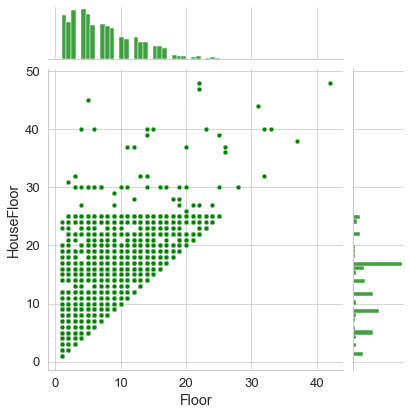

In [57]:
#посмотрим на график после замены
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind="scatter", height=6, color='green');

График выглядит гораздо лучше

**HouseYear**

In [58]:
train_df['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
8892         2020
3445         2020
6731         2020
9600         2020
15051        2020
9303         2020
2530         2020
7026         2020
12191        2020
4345         2020
6845         2020
8832         2020
14318        2020
3511         2020
13914        2020
8433         2020
2731         2020
14664        2020
6915         2020
12711        2019
16474        2019
15118        2019
15162        2019
4617         2019
1154         2019
10546        2019
9077         2019
12342        2019
5803         2019
3192         2019
5709         2019
2453         2019
728          2019
7722         2019
3183         2019
8967         2019
11459        2019
15980        2019
12934        2019
15840        2019
6508         2019
13226        2019
14651        2019
2230         2019
10061        2019
8807         2019
4540         2019
34           2019
251          2019
13161        2019
12390        2019
16364        2019
9275         2019
5421   

Всего 2 квартиры с явными ошибками заполнения

In [59]:
#заменим обе на 2020 год
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [60]:
#проверим результат
train_df['HouseYear'].sort_values(ascending=False)

Id
8892     2020
11607    2020
3445     2020
6731     2020
9600     2020
15051    2020
9303     2020
2530     2020
7026     2020
12191    2020
4345     2020
10814    2020
6845     2020
8832     2020
14318    2020
3511     2020
13914    2020
8433     2020
2731     2020
14664    2020
6915     2020
12711    2019
16474    2019
15118    2019
15162    2019
4617     2019
1154     2019
10546    2019
9077     2019
12342    2019
5803     2019
3192     2019
5709     2019
2453     2019
728      2019
7722     2019
3183     2019
8967     2019
11459    2019
15980    2019
12934    2019
15840    2019
6508     2019
13226    2019
14651    2019
2230     2019
10061    2019
8807     2019
4540     2019
34       2019
251      2019
13161    2019
12390    2019
16364    2019
9275     2019
5421     2019
14433    2019
5402     2019
12885    2019
9838     2019
1334     2019
194      2019
3619     2019
5835     2019
9088     2019
10987    2019
13899    2019
12719    2019
7866     2019
4982     2019
32       2019
102

**Обработка редких категорий**

**DistrictId**

In [61]:
print(train_df['DistrictId'].nunique(), 'уникальных значений в train')
print(test_df['DistrictId'].nunique(), 'уникальных значений в train')

205 уникальных значений в train
201 уникальных значений в train


In [62]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId':'DistrictSize'})
district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


В нескольких районах всего по 1 квартире

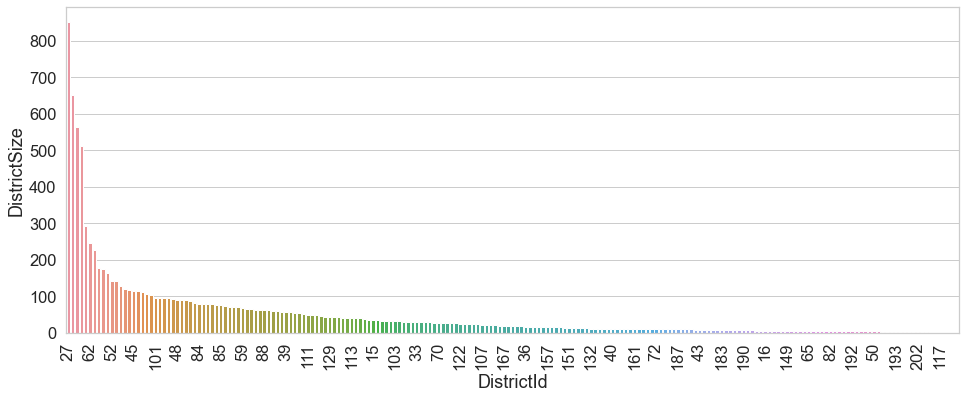

In [63]:
#посмотрим распределение на графике
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16,6))
sns.barplot(y='DistrictSize', x='DistrictId', data=district_size, order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']);
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [64]:
#посмотрим на районы, где больше 100 квартир
district_size.loc[district_size['DistrictSize'] > 100, :]

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


Получилось 20 районов, где больше 100 квартир

In [65]:
#внесём все популярные районы в список
district_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()
district_popular

['27',
 '1',
 '23',
 '6',
 '9',
 '62',
 '30',
 '58',
 '53',
 '21',
 '52',
 '8',
 '11',
 '46',
 '61',
 '45',
 '74',
 '34',
 '57',
 '44']

In [66]:
#заменим Id всех районов, не входящих в список самых популярных, на отличающеся число - 999
district_size.loc[~district_size['DistrictId'].isin(district_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)

In [67]:
#проверим результат
district_size

,DistrictId,DistrictSize
0,999,15
1,1,652
2,11,129
3,21,165
4,23,565
5,27,851
6,30,228
7,34,111
8,44,104
9,45,116


In [68]:
#заменим в train и test
train_df.loc[~train_df['DistrictId'].isin(district_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(district_popular), 'DistrictId'] = 999

In [69]:
#проверим результат
test_df['DistrictId'].value_counts()

999    2551
27      391
1       344
23      264
6       257
9       132
62      122
30      115
58       91
53       91
21       70
52       67
61       64
8        64
34       61
46       61
74       61
57       54
45       49
44       46
11       45
Name: DistrictId, dtype: int64

Больше половины (2551 из 5000) объектов недвижимости в test, находятся в других районах отличных от train. Признак возможно придётся удалить

# Построение новых признаков

**PriceOneRoom**  
Цена в пересчёте за одну комнату

In [70]:
train_df['PriceOneRoom'] = train_df['Price']/train_df['Rooms']
train_df['PriceOneRoom'].describe()

count    10,000.00
mean    124,245.13
std      50,723.97
min      20,585.69
25%      89,449.16
50%     114,961.11
75%     152,997.53
max     594,565.30
Name: PriceOneRoom, dtype: float64

In [71]:
#проверим результат
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,PriceOneRoom
Id,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,900.00,0,11,1,"184,966.93","92,483.47"
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,240.00,1,16,1,"300,009.45","100,003.15"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,229.00,1,3,1,"220,925.91","110,462.95"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23","87,808.11"
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,"2,078.00",2,4,1,"150,226.53","150,226.53"


Признак PriceOneRoom добавлен

**PriceSquare**  
Цена за 1 квадратный метр общей площади

In [72]:
train_df['PriceSquare'] = train_df['Price']/train_df['Square']
train_df['PriceSquare'].describe()

count   10,000.00
mean     3,892.16
std      1,251.63
min        752.59
25%      2,917.33
50%      3,908.65
75%      4,690.65
max     11,854.65
Name: PriceSquare, dtype: float64

In [73]:
#проверим результат
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,PriceOneRoom,PriceSquare
Id,,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,900.00,0,11,1,"184,966.93","92,483.47","3,854.96"
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,240.00,1,16,1,"300,009.45","100,003.15","4,567.49"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,229.00,1,3,1,"220,925.91","110,462.95","4,915.15"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23","87,808.11","3,291.59"
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,"2,078.00",2,4,1,"150,226.53","150,226.53","3,788.89"


Признак PriceSquare добавлен

**RoomSquare**  
Площадь одной комнаты  
Очевидно плохой признак, т.к. неизвестно как высчитывается площадь комнат (жилая или общая), а так же учитывается ли площадь кухни в количестве комнат и т.д.

# Отбор признаков

In [74]:
train_df.to_csv('train_prepared.csv')
test_df.to_csv('test_prepared.csv')

In [75]:
#отобразим список признаков (колонок в датасете)
feature_names = train_df.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'PriceOneRoom',
 'PriceSquare']

In [77]:
target_name = ['Price']
feature_names = [
 #'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
# 'Price',
# 'PriceOneRoom',
# 'PriceSquare'
]

In [78]:
X = train_df[feature_names]
y = train_df[target_name]

X_test = test_df[feature_names]

In [79]:
len(feature_names)

17

# Построение модели Случайный Лес (Random Forest)

**Перекрестная проверка модели**

In [80]:
forest = RandomForestRegressor(max_depth=19,
                              max_features=6,
                              n_estimators=100,
                              random_state=42)

In [81]:
#кросс-валидация на 10 фолдов
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [82]:
cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.74096


**Важность признаков**

In [83]:
#отберём признаки и отсортируем по важности
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

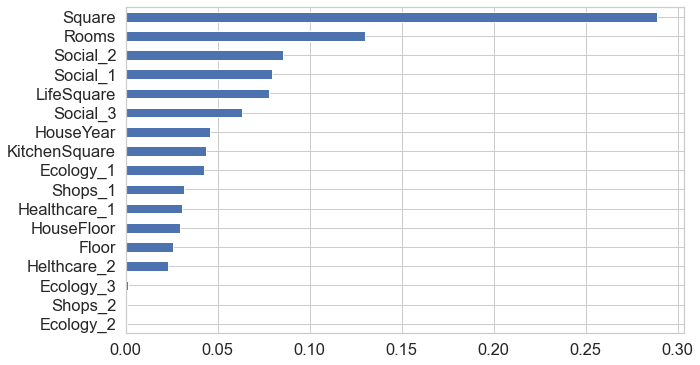

In [84]:
#построим график для наглядности
feat_importances.plot(kind='barh', figsize=(10, 6));

**Настройка гиперпараметров модели**

In [85]:
params = {
    'n_estimators': [400],
    'max_depth': [18,19,20],
    'max_features': [5,6,7]
}

In [86]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

{'max_depth': 18, 'max_features': 5, 'n_estimators': 400}
R2 на train: 0.74604


**Прогнозирование на test**

In [87]:
forest_best = forest_grid.best_estimator_

y_pred = forest_best.predict(X_test)

In [88]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"159,181.08"
1,15856,"212,832.85"
2,5480,"220,230.89"
3,15664,"331,834.13"
4,14275,"136,942.06"


In [89]:
#запись результатов в итоговый файл
preds.to_csv('submission.csv', index=False)

# Подведение итогов и общий вывод:

Первичная обработка данных выявила некоторые ошибки в заполнении данных (ошибки в дате постройки дома), а таже появились вопросы к некоторыми данным, таким как общая площадь дома, жилая, кухня. Во многих квартирах также этаж квартиры оказался выше общей этажности дома. Соответственно заполнение пропусков и обработка выбросов может быть произведена более точно.  

Построение новых признаков дало некоторый эффект, поэтому для улучшения модели можно пострараться построить больше признаков.  

Возможно, другой алгоритм может выдать лучший результат, но значение метрики R2 на построенной модели Случайного Леса (Random Forest) соответсвует заявленому в задании критерию (R2 > 0.5), следовательно задача считается выполненной и не требует тестирования результатов работы других моделей.  